In [ ]:
##Preliminary imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# GDSC Data

## Given Methodology

### Defining the model

In [ ]:
##For this I have removed the repeated lines from original model
def get_data():
    path = os.getcwd()
    ##Read in a dataframe with drug response for each of the cell lines
    cluster_data = pd.read_csv('/content/drive/MyDrive/DROEG/gdsc_fulldrugResponse.csv',
                               index_col=0)
    ##They fill the drug responses that have no value to the mean response for that specific drug
    cluster_data.fillna(cluster_data.mean(),inplace=True)
    return cluster_data,cluster_data

In [ ]:
def cluster(cluster_data):
    cluster_result = {"drug":[],
                      "threshold_1":[],
                      "threshold_2":[]}
    ##Selecting each individual drug
    for column in cluster_data.columns:
        series =  cluster_data[column].loc[pd.notnull(cluster_data[column])]
        ##2 clusters as either effective or not
        ##Also set n_init to remove warnings
        cluster = KMeans(n_clusters=2, max_iter=1000, n_init=10).fit(series.values.reshape(-1,1))
        ##make a label for each named as type
        after_cluster = pd.concat([cluster_data[column],pd.Series(cluster.labels_,
                                                                  index=series.index,
                                                                  name="type")],axis=1)
        cluster_group = after_cluster.groupby("type")##group by the type labels
        possible_list = []##make a list of the highest and lowest values in each cluster
        for label,items in cluster_group:
            possible_list.append(items[column].min())
            possible_list.append(items[column].max())

        possible_list.sort()
        threshold_1 = possible_list[1]##first threshold is highest value of lower cluster
        threshold_2 = possible_list[2]##second threshold is lowest value of upper cluster

        cluster_result["drug"].append(column)##Add the column which is the drug name as the first column
        cluster_result["threshold_1"].append(threshold_1)##Add each threshold value
        cluster_result["threshold_2"].append(threshold_2)

    cluster_result_df = pd.DataFrame(cluster_result)

    return cluster_result_df

In [ ]:
def get_independent_data():
    ##Store current working directory
    path = os.getcwd()
    cluster_data,medicine = get_data()
    cluster_result_df = cluster(cluster_data)
    data_1 = pd.read_csv("/content/drive/MyDrive/DROEG/cnv_fullgdsc.csv",index_col=0)
    data_1.fillna(0,inplace=True)
    ##For crispr, methylation and mRNA standardise by each column
    data_2 = pd.read_csv("/content/drive/MyDrive/DROEG/crispr_fullgdsc.csv",index_col=0)
    data_2.fillna(data_2.mean(),inplace=True)
    data_2 = data_2.apply(lambda x: (x-x.mean())/x.std(),axis=0)
    data_3 = pd.read_csv("/content/drive/MyDrive/DROEG/meth_fullgdsc.csv",index_col=0)
    data_3.fillna(data_3.mean(),inplace=True)
    data_3 = data_3.apply(lambda x: (x-x.mean())/x.std(),axis=0)
    data_4 = pd.read_csv("/content/drive/MyDrive/DROEG/mRNA_fullgdsc.csv",index_col=0)
    data_4.fillna(data_4.mean(),inplace=True)
    data_4 = data_4.apply(lambda x: (x-x.mean())/x.std(),axis=0)
    data_5 = pd.read_csv("/content/drive/MyDrive/DROEG/mutation_fullgdsc.csv",index_col=0)
    data_5.fillna(0,inplace=True)

    ##threshold is taking each drug and highest value of lowest cluster
    threshold = cluster_result_df.loc[:,["drug","threshold_1"]]
    ##y_dummy has the same as the regression data but now 0 if ineffective and 1 if effective
    y_dummy = pd.DataFrame(index = medicine.index,
                           columns = medicine.columns)
    for cellline in medicine.index:
        for column in medicine.columns:
            threshold_value = threshold.loc[threshold["drug"] == column,"threshold_1"].values[0]
            if medicine[column][cellline] > threshold_value:
                y_dummy[column][cellline] = 0
            else:
                y_dummy[column][cellline] = 1
    return data_1,data_2,data_3,data_4,data_5,medicine,threshold,y_dummy

In [ ]:
class Drug_response:

    def __init__(self, data_1, data_2, data_3, data_4, data_5, medicine, threshold, y_dummy):
        self.data_1 = data_1
        self.data_2 = data_2
        self.data_3 = data_3
        self.data_4 = data_4
        self.data_5 = data_5
        self.y_values = medicine
        self.threshold = threshold
        self.y_dummy = y_dummy
        self.best_models = pd.Series(index=self.y_values.columns)
        self.predict_values = pd.DataFrame(columns = self.y_values.columns,##The model predicts the values first
                                               index = self.y_values.index)
        self.predict_dummy = pd.DataFrame(columns = self.y_values.columns,##Then converts this into the binary value
                                               index = self.y_values.index)

    def feature_selected(self,method="spearman"):##Default is spearman although they set this to pearsons in the code
        correlated_result = {"medi":[],
                             "data_num":[],
                             "gen_name":[],
                             "score":[]}

        for medi in self.y_values.columns:
            print("feature selection of data 1 and {}".format(medi))
            data_1_score = []
            data_1_gene = []##A list of each gene and corresponding score for each drug
            if len(self.data_1[self.data_1.columns[0]].unique()) < 5: #判断是否离散
                for gene in self.data_1.columns:
                    if len(self.data_1[gene].unique()) == 1:
                        continue
                    x = pd.Series(self.data_1[gene],name="x")
                    y = pd.Series(self.y_values[medi],name="y")
                    model = anova_lm(ols('y~C(x)',data=pd.concat([x,y],axis=1)).fit())
                    F_statistic = model["F"][0]
                    data_1_score.append(F_statistic)
                    data_1_gene.append(gene)
            else:
                for gene in self.data_1.columns:
                    correl = abs(self.y_values[medi].corr(self.data_1[gene],method=method))
                    data_1_score.append(correl)
                    data_1_gene.append(gene)
            data_1_score_mean = np.array(data_1_score).mean()
            data_1_score_std = np.array(data_1_score).std()
            for i in range(len(data_1_score)):
                if data_1_score[i] >= data_1_score_mean + 2*data_1_score_std:##If score is greater than two std from mean then feature is selected
                    correlated_result["medi"].append(medi)
                    correlated_result["data_num"].append(1)
                    correlated_result["gen_name"].append(data_1_gene[i])
                    correlated_result["score"].append(data_1_score[i])


            print("feature selection of data 2 and {}".format(medi))
            data_2_score = []
            data_2_gene = []
            if len(self.data_2[self.data_2.columns[0]].unique()) < 5: #判断是否离散
                for gene in self.data_2.columns:
                    if len(self.data_2[gene].unique()) == 1:
                        continue
                    x = pd.Series(self.data_2[gene],name="x")
                    y = pd.Series(self.y_values[medi],name="y")
                    model = anova_lm(ols('y~C(x)',data=pd.concat([x,y],axis=1)).fit())
                    F_statistic = model["F"][0]
                    data_2_score.append(F_statistic)
                    data_2_gene.append(gene)
            else:
                for gene in self.data_2.columns:
                    correl = abs(self.y_values[medi].corr(self.data_2[gene],method=method))
                    data_2_score.append(correl)
                    data_2_gene.append(gene)
            data_2_score_mean = np.array(data_2_score).mean()
            data_2_score_std = np.array(data_2_score).std()
            for i in range(len(data_2_score)):
                if data_2_score[i] >= data_2_score_mean + 2*data_2_score_std:
                    correlated_result["medi"].append(medi)
                    correlated_result["data_num"].append(2)
                    correlated_result["gen_name"].append(data_2_gene[i])
                    correlated_result["score"].append(data_2_score[i])

            print("feature selection of data 3 and {}".format(medi))
            data_3_score = []
            data_3_gene = []
            if len(self.data_3[self.data_3.columns[0]].unique()) < 5: #判断是否离散
                for gene in self.data_3.columns:
                    if len(self.data_3[gene].unique()) == 1:
                        continue
                    x = pd.Series(self.data_3[gene],name="x")
                    y = pd.Series(self.y_values[medi],name="y")
                    model = anova_lm(ols('y~C(x)',data=pd.concat([x,y],axis=1)).fit())
                    F_statistic = model["F"][0]
                    data_3_score.append(F_statistic)
                    data_3_gene.append(gene)
            else:
                for gene in self.data_3.columns:
                    correl = abs(self.y_values[medi].corr(self.data_3[gene],method=method))
                    data_3_score.append(correl)
                    data_3_gene.append(gene)
            data_3_score_mean = np.array(data_3_score).mean()
            data_3_score_std = np.array(data_3_score).std()
            for i in range(len(data_3_score)):
                if data_3_score[i] >= data_3_score_mean + 2*data_3_score_std:
                    correlated_result["medi"].append(medi)
                    correlated_result["data_num"].append(3)
                    correlated_result["gen_name"].append(data_3_gene[i])
                    correlated_result["score"].append(data_3_score[i])

            print("feature selection of data 4 and {}".format(medi))
            data_4_score = []
            data_4_gene = []
            if len(self.data_4[self.data_4.columns[0]].unique()) < 5: #判断是否离散
                for gene in self.data_4.columns:
                    if len(self.data_4[gene].unique()) == 1:
                        continue
                    x = pd.Series(self.data_4[gene],name="x")
                    y = pd.Series(self.y_values[medi],name="y")
                    model = anova_lm(ols('y~C(x)',data=pd.concat([x,y],axis=1)).fit())
                    F_statistic = model["F"][0]
                    data_4_score.append(F_statistic)
                    data_4_gene.append(gene)
            else:
                for gene in self.data_4.columns:
                    correl = abs(self.y_values[medi].corr(self.data_4[gene],method=method))
                    data_4_score.append(correl)
                    data_4_gene.append(gene)
            data_4_score_mean = np.array(data_4_score).mean()
            data_4_score_std = np.array(data_4_score).std()
            for i in range(len(data_4_score)):
                if data_4_score[i] >= data_4_score_mean + 2*data_4_score_std:
                    correlated_result["medi"].append(medi)
                    correlated_result["data_num"].append(4)
                    correlated_result["gen_name"].append(data_4_gene[i])
                    correlated_result["score"].append(data_4_score[i])

            print("feature selection of data 5 and {}".format(medi))
            data_5_score = []
            data_5_gene = []
            if len(self.data_5[self.data_5.columns[0]].unique()) < 5: #判断是否离散
                for gene in self.data_5.columns:
                    if len(self.data_5[gene].unique()) == 1:
                        continue
                    x = pd.Series(self.data_5[gene],name="x")
                    y = pd.Series(self.y_values[medi],name="y")
                    model = anova_lm(ols('y~C(x)',data=pd.concat([x,y],axis=1)).fit())
                    F_statistic = model["F"][0]
                    data_5_score.append(F_statistic)
                    data_5_gene.append(gene)
            else:
                for gene in self.data_5.columns:
                    correl = abs(self.y_values[medi].corr(self.data_5[gene],method=method))
                    data_5_score.append(correl)
                    data_5_gene.append(gene)
            data_5_score_mean = np.array(data_5_score).mean()
            data_5_score_std = np.array(data_5_score).std()
            for i in range(len(data_5_score)):
                if data_5_score[i] >= data_5_score_mean + 2*data_5_score_std:
                    correlated_result["medi"].append(medi)
                    correlated_result["data_num"].append(5)
                    correlated_result["gen_name"].append(data_5_gene[i])
                    correlated_result["score"].append(data_5_score[i])

        self.selected_features = pd.DataFrame(correlated_result)

    def Run_Model_On_Row(self, Series, Model, param_grid, Include_data_1=1,Include_data_2=1,
                  Include_data_3=1,Include_data_4=1,Include_data_5=1):

        After_selected = pd.DataFrame()
        for_select = self.selected_features.loc[self.selected_features.medi==Series.name,:]
        for_select_1 = for_select.loc[for_select.data_num==1,:]
        for_select_2 = for_select.loc[for_select.data_num==2,:]
        for_select_3 = for_select.loc[for_select.data_num==3,:]
        for_select_4 = for_select.loc[for_select.data_num==4,:]
        for_select_5 = for_select.loc[for_select.data_num==5,:]

        print("processing the model of {}".format(Series.name))
        if Include_data_1 == 1:
            if len(for_select_1.index) > 0:
                for gene in for_select_1.gen_name:
                    After_selected = pd.concat([After_selected,
                                            self.data_1[gene]],axis=1)
        if Include_data_2 == 1:
            if len(for_select_2.index) > 0:
                for gene in for_select_2.gen_name:
                    After_selected = pd.concat([After_selected,
                                            self.data_2[gene]],axis=1)
        if Include_data_3 == 1:
            if len(for_select_3.index) > 0:
                for gene in for_select_3.gen_name:
                    After_selected = pd.concat([After_selected,
                                            self.data_3[gene]],axis=1)
        if Include_data_4 == 1:
            if len(for_select_4.index) > 0:
                for gene in for_select_4.gen_name:
                    After_selected = pd.concat([After_selected,
                                            self.data_4[gene]],axis=1)
        if Include_data_5 == 1:
            if len(for_select_5.index) > 0:
                for gene in for_select_5.gen_name:
                    After_selected = pd.concat([After_selected,
                                            self.data_5[gene]],axis=1)
        print("Start to run the model")
        threshold_value = self.threshold.loc[self.threshold["drug"]==Series.name,"threshold_1"].values[0]##Take the threshold value for the specific drug
        y = self.y_values[Series.name]
        X = After_selected
        combined = pd.concat([X,y],axis=1)
        grid = GridSearchCV(Model, param_grid, cv=5)##Use each of the parameters to find the best model
        grid.fit(X,y)
        best_model = grid.best_estimator_##Save the best model
        self.best_models[Series.name] = best_model
        for cellline in X.index:
            wait_for_pre_X = X.iloc[X.index == cellline,:]
            X_train = X.iloc[X.index != cellline, :]
            y_train = combined.iloc[X.index != cellline, -1]
            best_model.fit(X_train, y_train)
            ##changed this to save the model from joblib.dump(best_model,r"\content\drive\MyDrive\{}.sav".format(Series.name))
            #file_path = "/content/drive/MyDrive/{}.sav".format(Series.name)
            #directory = os.path.dirname(file_path)
            #if not os.path.exists(directory):
              #os.makedirs(directory)
            #joblib.dump(best_model, file_path)
            predict_value = best_model.predict(wait_for_pre_X)

            self.predict_values[Series.name][cellline] = predict_value[0]

            if predict_value[0] > threshold_value:
                self.predict_dummy[Series.name][cellline] = 0
            else:
                self.predict_dummy[Series.name][cellline] = 1

    def Run_Model(self, Model, param_grid, Include_data_1=1,Include_data_2=1,
                  Include_data_3=1,Include_data_4=1,Include_data_5=1):
        self.y_values.apply(self.Run_Model_On_Row,
                            args=(Model,param_grid,Include_data_1,Include_data_2,
                                  Include_data_3,Include_data_4,Include_data_5),
                            axis=0)

    def score(self):
        pp = 0
        pn = 0
        nnp = 0
        nn = 0
        correct = 0
        self.confuse_matrix = pd.DataFrame(index=["pre_p","pre_n"],
                                           columns=["actual_p","actual_n"])

        final_result = {"medicine":[],
                        "accuracy":[],
                        "precision":[],
                        "specificity":[],
                        "sensitivity":[]}

        for medi in self.predict_dummy.columns:

            print(f"scoring {medi}")
            medi_correct = 0
            medi_pp = 0
            medi_pn = 0
            medi_np = 0
            medi_nn = 0
            for cellline in self.predict_dummy.index:
                pre_y_dummy = self.predict_dummy[medi][cellline]
                actual_y_dummy = self.y_dummy[medi][cellline]
                if pre_y_dummy == actual_y_dummy:
                    correct += 1
                    medi_correct += 1
                    if actual_y_dummy == 1:
                        pp += 1
                        medi_pp += 1
                    else:
                        nn += 1
                        medi_nn += 1
                else:
                    if actual_y_dummy == 1:
                        nnp += 1
                        medi_np += 1
                    else:
                        pn += 1
                        medi_pn += 1
            final_result["medicine"].append(medi)
            final_result["accuracy"].append(medi_correct/len(self.y_values.index))
            if medi_pp+medi_np == 0:
                final_result["sensitivity"].append(0)
            else:
                final_result["sensitivity"].append(medi_pp/(medi_pp+medi_np))
            if medi_pp+medi_pn == 0:
                final_result["precision"].append(0)
            else:
                final_result["precision"].append(medi_pp/(medi_pp+medi_pn))
            if medi_nn+medi_pn == 0:
                final_result["specificity"].append(0)
            else:
                final_result["specificity"].append(medi_nn/(medi_nn+medi_pn))

        self.final_df = pd.DataFrame(final_result)
        self.confuse_matrix.loc["pre_p","actual_p"] = pp
        self.confuse_matrix.loc["pre_p","actual_n"] = pn
        self.confuse_matrix.loc["pre_n","actual_p"] = nnp
        self.confuse_matrix.loc["pre_n","actual_n"] = nn
        print("accuracy is ",correct/(len(self.predict_dummy.index)*len(self.predict_dummy.columns)))

In [ ]:
class Drug_response_new(Drug_response):

    def __init__(self,selected_features,data_1,data_2,data_3,data_4,data_5,medicine,threshold,y_dummy):
        Drug_response.__init__(self,data_1,data_2,data_3,data_4,data_5,
                               medicine,threshold,y_dummy)
        self.selected_features = selected_features

In [ ]:
data_1,data_2,data_3,data_4,data_5,medicine,threshold,y_dummy = get_independent_data()##took 2 minutes to run

### EDA

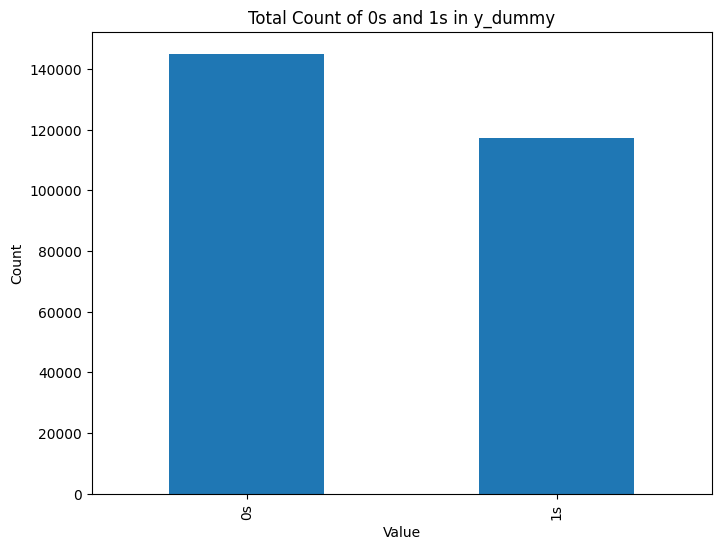

In [ ]:
##Compare the distribution of effective and non effective
total_counts = y_dummy.apply(pd.Series.value_counts).sum(axis=1)

total_counts.plot(kind='bar', figsize=(8, 6))
plt.title('Total Count of 0s and 1s in y_dummy')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0s', '1s'])
plt.show()

### Feature Selection

In [ ]:
drug_response = Drug_response(data_1, data_2, data_3, data_4, data_5,
                              medicine,threshold,y_dummy)

In [ ]:
drug_response.feature_selected(method="pearson")##took 1 hour 10 minutes to run

feature selection of data 1 and TL-2-105
feature selection of data 2 and TL-2-105
feature selection of data 3 and TL-2-105
feature selection of data 4 and TL-2-105
feature selection of data 5 and TL-2-105
feature selection of data 1 and TAK-715
feature selection of data 2 and TAK-715
feature selection of data 3 and TAK-715
feature selection of data 4 and TAK-715
feature selection of data 5 and TAK-715
feature selection of data 1 and CP466722
feature selection of data 2 and CP466722
feature selection of data 3 and CP466722
feature selection of data 4 and CP466722
feature selection of data 5 and CP466722
feature selection of data 1 and BMS-345541
feature selection of data 2 and BMS-345541
feature selection of data 3 and BMS-345541
feature selection of data 4 and BMS-345541
feature selection of data 5 and BMS-345541
feature selection of data 1 and Genentech Cpd 10
feature selection of data 2 and Genentech Cpd 10
feature selection of data 3 and Genentech Cpd 10
feature selection of data 4 

In [ ]:
Features = drug_response.selected_features

In [ ]:
##For reloading selected features rather than running again
Features=pd.read_excel("/content/drive/MyDrive/DROEG/selected_features_544.xlsx")
drug_response.selected_features=Features

### Evaluation

In [ ]:
##Selecting only the cell lines that had all required features for the model
common_indices_filtered = data_1.index.intersection(medicine.index).intersection(y_dummy.index)
medicine_filtered = medicine.loc[common_indices_filtered]
y_dummy_filtered = y_dummy.loc[common_indices_filtered]
data_1_filtered=data_1.loc[common_indices_filtered]
data_2_filtered=data_2.loc[common_indices_filtered]
data_3_filtered=data_3.loc[common_indices_filtered]
data_4_filtered=data_4.loc[common_indices_filtered]
data_5_filtered=data_5.loc[common_indices_filtered]

In [ ]:
y_dummy_filtered.to_excel("/content/drive/MyDrive/DROEG/y_dummy_gdsc.xlsx")

In [ ]:
##To show the now 116 cell lines from the original 990
data_1_filtered

,AGO2,AKT1,AKT2,AKT3,ALK,AURKA,AXL,BCL6,BRAF,BRD4,...,RAF1,RHEB,RHOA,RICTOR,ROS1,RUNX1,SRC,TERT,VEGFA,YAP1
A2058,1,1,0,1,0,0,0,1,1,-1,...,0,1,0,1,0,0,0,1,-1,0
HCC1419,1,-1,0,0,1,1,0,0,-1,0,...,0,-1,-1,0,0,0,1,1,0,-1
C32,0,1,-1,0,0,0,-1,0,1,-1,...,0,1,-1,0,0,0,0,0,-1,1
AU565,-1,1,-1,0,1,1,-1,1,1,-1,...,-1,1,-1,1,-1,1,1,1,-1,1
SW1088,-1,1,-1,-1,0,1,-1,0,1,-1,...,0,1,0,1,0,1,1,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OVTOKO,0,1,0,1,1,1,0,0,1,0,...,0,1,0,1,0,0,1,1,0,-1
SU8686,1,1,1,0,0,1,-1,0,-1,-1,...,-1,-1,-1,0,0,-1,1,0,1,0
SW1271,-1,1,-1,-1,1,1,-1,0,0,0,...,1,0,-1,1,0,-1,1,1,1,1
PEO1,1,1,0,1,0,1,0,1,1,1,...,1,1,-1,-1,0,-1,0,0,-1,0


In [ ]:
##Apply to only these 116 cell lines
drug_response = Drug_response(data_1_filtered, data_2_filtered, data_3_filtered,
                              data_4_filtered, data_5_filtered, medicine_filtered,
                              threshold, y_dummy_filtered)

In [ ]:
drug_response_new = Drug_response_new(Features, data_1_filtered, data_2_filtered,
                                      data_3_filtered, data_4_filtered, data_5_filtered,
                                      medicine_filtered, threshold, y_dummy_filtered)

In [ ]:
param_grid = [
        {'kernel':['rbf'],'C':[1,5,10,30,50],'gamma':[0.0001,0.001,0.01,0.1,1]}
        ]
##Took 25 minutes to run
drug_response_new.Run_Model(SVR(), param_grid,Include_data_1=1, Include_data_2=1, Include_data_3=1,Include_data_4=1,Include_data_5=1)

processing the model of TL-2-105
Start to run the model
processing the model of TAK-715
Start to run the model
processing the model of CP466722
Start to run the model
processing the model of BMS-345541
Start to run the model
processing the model of Genentech Cpd 10
Start to run the model
processing the model of GSK429286A
Start to run the model
processing the model of Ruxolitinib
Start to run the model
processing the model of SB-715992
Start to run the model
processing the model of ZSTK474
Start to run the model
processing the model of KIN001-102
Start to run the model
processing the model of CAL-101
Start to run the model
processing the model of GW-2580
Start to run the model
processing the model of BMS-708163
Start to run the model
processing the model of BX-912
Start to run the model
processing the model of LY317615
Start to run the model
processing the model of WZ3105
Start to run the model
processing the model of XMD14-99
Start to run the model
processing the model of CP724714
Sta

In [ ]:
drug_response_new.score()

scoring TL-2-105
scoring TAK-715
scoring CP466722
scoring BMS-345541
scoring Genentech Cpd 10
scoring GSK429286A
scoring Ruxolitinib
scoring SB-715992
scoring ZSTK474
scoring KIN001-102
scoring CAL-101
scoring GW-2580
scoring BMS-708163
scoring BX-912
scoring LY317615
scoring WZ3105
scoring XMD14-99
scoring CP724714
scoring JW-7-24-1
scoring ABT-869
scoring GSK2126458
scoring PHA-793887
scoring TG101348
scoring QL-XI-92
scoring XMD15-27
scoring QL-XII-47
scoring AC220
scoring EKB-569
scoring Masitinib
scoring OSI-930
scoring XMD13-2
scoring Bleomycin (50 uM)
scoring AT-7519
scoring XL-184
scoring NPK76-II-72-1
scoring NG-25
scoring TL-1-85
scoring VX-11e
scoring FR-180204
scoring Zibotentan, ZD4054
scoring BIX02189
scoring KIN001-236
scoring KIN001-055
scoring KIN001-266
scoring NVP-BHG712
scoring PIK-93
scoring TPCA-1
scoring Y-39983
scoring YM201636
scoring AV-951
scoring GSK690693
scoring KIN001-270
scoring CH5424802
scoring KIN001-244
scoring KIN001-260
scoring SB52334
scoring AS60

In [ ]:
drug_response_new.final_df

,medicine,accuracy,precision,specificity,sensitivity
0,TL-2-105,0.870690,0.588235,0.928571,0.555556
1,TAK-715,0.801724,0.786885,0.775862,0.827586
2,CP466722,0.862069,0.938462,0.906977,0.835616
3,BMS-345541,0.801724,0.858974,0.702703,0.848101
4,Genentech Cpd 10,0.818966,0.863636,0.808511,0.826087
...,...,...,...,...,...
260,Cyclopamine,0.974138,0.750000,0.990991,0.600000
261,VX-680,0.931034,1.000000,1.000000,0.200000
262,JW-7-52-1,0.948276,0.955357,0.375000,0.990741
263,Erlotinib,0.905172,0.000000,1.000000,0.000000


In [ ]:
drug_response_new.confuse_matrix

,actual_p,actual_n
pre_p,10600,2133
pre_n,2759,15248


## Train and Test Split

In [ ]:
##Sorting index to ensure split in the same place
data_1_filtered=data_1_filtered.sort_index()
data_2_filtered=data_2_filtered.sort_index()
data_3_filtered=data_3_filtered.sort_index()
data_4_filtered=data_4_filtered.sort_index()
data_5_filtered=data_5_filtered.sort_index()
medicine_filtered=medicine_filtered.sort_index()
y_dummy_filtered=y_dummy_filtered.sort_index()

In [ ]:
##Using an 80:20 split and setting the random state to ensure replication
data_1_train, data_1_test = train_test_split(data_1_filtered, test_size=0.2, random_state=0)
data_2_train, data_2_test = train_test_split(data_2_filtered, test_size=0.2, random_state=0)
data_3_train, data_3_test = train_test_split(data_3_filtered, test_size=0.2, random_state=0)
data_4_train, data_4_test = train_test_split(data_4_filtered, test_size=0.2, random_state=0)
data_5_train, data_5_test = train_test_split(data_5_filtered, test_size=0.2, random_state=0)
medicine_train, medicine_test = train_test_split(medicine_filtered, test_size=0.2, random_state=0)
y_dummy_train, y_dummy_test = train_test_split(y_dummy_filtered, test_size=0.2, random_state=0)

In [ ]:
##Using only the train values to select features
drug_response = Drug_response(data_1_train, data_2_train, data_3_train, data_4_train, data_5_train,
                              medicine_train,threshold,y_dummy_train)

In [ ]:
drug_response.feature_selected(method="pearson")##Took 35 minutes to run

feature selection of data 1 and TL-2-105
feature selection of data 2 and TL-2-105
feature selection of data 3 and TL-2-105
feature selection of data 4 and TL-2-105
feature selection of data 5 and TL-2-105
feature selection of data 1 and TAK-715
feature selection of data 2 and TAK-715
feature selection of data 3 and TAK-715
feature selection of data 4 and TAK-715
feature selection of data 5 and TAK-715
feature selection of data 1 and CP466722
feature selection of data 2 and CP466722
feature selection of data 3 and CP466722
feature selection of data 4 and CP466722
feature selection of data 5 and CP466722
feature selection of data 1 and BMS-345541
feature selection of data 2 and BMS-345541
feature selection of data 3 and BMS-345541
feature selection of data 4 and BMS-345541
feature selection of data 5 and BMS-345541
feature selection of data 1 and Genentech Cpd 10
feature selection of data 2 and Genentech Cpd 10
feature selection of data 3 and Genentech Cpd 10
feature selection of data 4 

In [ ]:
train_features=drug_response.selected_features

In [ ]:
drug_response_new = Drug_response_new(train_features, data_1_test, data_2_test,
                                      data_3_test, data_4_test, data_5_test,
                                      medicine_test, threshold,y_dummy_test)

In [ ]:
drug_response_new.Run_Model(SVR(), param_grid,Include_data_1=1, Include_data_2=1, Include_data_3=1,Include_data_4=1,Include_data_5=1)
##Took 16 minutes to run

processing the model of TL-2-105
Start to run the model
processing the model of TAK-715
Start to run the model
processing the model of CP466722
Start to run the model
processing the model of BMS-345541
Start to run the model
processing the model of Genentech Cpd 10
Start to run the model
processing the model of GSK429286A
Start to run the model
processing the model of Ruxolitinib
Start to run the model
processing the model of SB-715992
Start to run the model
processing the model of ZSTK474
Start to run the model
processing the model of KIN001-102
Start to run the model
processing the model of CAL-101
Start to run the model
processing the model of GW-2580
Start to run the model
processing the model of BMS-708163
Start to run the model
processing the model of BX-912
Start to run the model
processing the model of LY317615
Start to run the model
processing the model of WZ3105
Start to run the model
processing the model of XMD14-99
Start to run the model
processing the model of CP724714
Sta

In [ ]:
drug_response_new.score()

scoring TL-2-105
scoring TAK-715
scoring CP466722
scoring BMS-345541
scoring Genentech Cpd 10
scoring GSK429286A
scoring Ruxolitinib
scoring SB-715992
scoring ZSTK474
scoring KIN001-102
scoring CAL-101
scoring GW-2580
scoring BMS-708163
scoring BX-912
scoring LY317615
scoring WZ3105
scoring XMD14-99
scoring CP724714
scoring JW-7-24-1
scoring ABT-869
scoring GSK2126458
scoring PHA-793887
scoring TG101348
scoring QL-XI-92
scoring XMD15-27
scoring QL-XII-47
scoring AC220
scoring EKB-569
scoring Masitinib
scoring OSI-930
scoring XMD13-2
scoring Bleomycin (50 uM)
scoring AT-7519
scoring XL-184
scoring NPK76-II-72-1
scoring NG-25
scoring TL-1-85
scoring VX-11e
scoring FR-180204
scoring Zibotentan, ZD4054
scoring BIX02189
scoring KIN001-236
scoring KIN001-055
scoring KIN001-266
scoring NVP-BHG712
scoring PIK-93
scoring TPCA-1
scoring Y-39983
scoring YM201636
scoring AV-951
scoring GSK690693
scoring KIN001-270
scoring CH5424802
scoring KIN001-244
scoring KIN001-260
scoring SB52334
scoring AS60

In [ ]:
drug_response_new.final_df

,medicine,accuracy,precision,specificity,sensitivity
0,TL-2-105,0.791667,0.000000,1.000000,0.000000
1,TAK-715,0.583333,0.000000,1.000000,0.000000
2,CP466722,0.625000,0.687500,0.444444,0.733333
3,BMS-345541,0.750000,0.750000,0.000000,1.000000
4,Genentech Cpd 10,0.666667,0.666667,0.000000,1.000000
...,...,...,...,...,...
260,Cyclopamine,0.958333,0.000000,1.000000,0.000000
261,VX-680,0.958333,0.000000,1.000000,0.000000
262,JW-7-52-1,0.875000,0.875000,0.000000,1.000000
263,Erlotinib,0.916667,0.000000,1.000000,0.000000


In [ ]:
drug_response_new.confuse_matrix

,actual_p,actual_n
pre_p,1790,696
pre_n,950,2924


# CCLE Data

## Original Methodology

### Redefine Model

In [ ]:
def get_data():
    path = os.getcwd()
    ##Read in a dataframe with drug response for each of the cell lines
    cluster_data = pd.read_csv('/content/drive/MyDrive/DROEG/drugResponse_ccle.csv',
                               index_col=0)
    ##They fill the drug responses that have no value to the mean response for that specific drug
    cluster_data.fillna(cluster_data.mean(),inplace=True)

    cluster_data=8-cluster_data
    return cluster_data,cluster_data

In [ ]:
def get_independent_data():
    ##Store current working directory
    path = os.getcwd()
    cluster_data,medicine = get_data()
    cluster_result_df = cluster(cluster_data)
    data_1 = pd.read_csv("/content/drive/MyDrive/DROEG/cnv_ccle.csv",index_col=0)
    data_1.fillna(0,inplace=True)
    ##For crispr, methylation and mRNA standardise by each column
    data_2 = pd.read_csv("/content/drive/MyDrive/DROEG/crispr_ccle.csv",index_col=0)
    data_2.fillna(data_2.mean(),inplace=True)
    data_2 = data_2.apply(lambda x: (x-x.mean())/x.std(),axis=0)
    data_3 = pd.read_csv("/content/drive/MyDrive/DROEG/meth_ccle.csv",index_col=0)
    data_3.fillna(data_3.mean(),inplace=True)
    data_3 = data_3.apply(lambda x: (x-x.mean())/x.std(),axis=0)
    data_4 = pd.read_csv("/content/drive/MyDrive/DROEG/mrna_ccle.csv",index_col=0)
    data_4.fillna(data_4.mean(),inplace=True)
    data_4 = data_4.apply(lambda x: (x-x.mean())/x.std(),axis=0)
    data_5 = pd.read_csv("/content/drive/MyDrive/DROEG/mutation_ccle.csv",index_col=0)
    data_5.fillna(0,inplace=True)

    ##threshold is taking each drug and highest value of lowest cluster
    threshold = cluster_result_df.loc[:,["drug","threshold_1"]]
    ##y_dummy has the same as the regression data but now 0 if ineffective and 1 if effective
    y_dummy = pd.DataFrame(index = medicine.index,
                           columns = medicine.columns)
    for cellline in medicine.index:
        for column in medicine.columns:
            threshold_value = threshold.loc[threshold["drug"] == column,"threshold_1"].values[0]
            if medicine[column][cellline] > threshold_value:
                y_dummy[column][cellline] = 0
            else:
                y_dummy[column][cellline] = 1
    return data_1,data_2,data_3,data_4,data_5,medicine,threshold,y_dummy

In [ ]:
data_1_ccle,data_2_ccle,data_3_ccle,data_4_ccle,data_5_ccle,medicine_ccle,threshold_ccle,y_dummy_ccle = get_independent_data()

In [ ]:
y_dummy_ccle.to_excel("/content/drive/MyDrive/DROEG/y_dummy_ccle.xlsx")

### Feature Selection

In [ ]:
drug_response = Drug_response(data_1_ccle, data_2_ccle, data_3_ccle, data_4_ccle,
                              data_5_ccle, medicine_ccle,threshold_ccle,y_dummy_ccle)

In [ ]:
drug_response.feature_selected(method="pearson")##Took 4 minutes

In [ ]:
Features_ccle = drug_response.selected_features

In [ ]:
Features_ccle.to_excel("/content/drive/MyDrive/DROEG/features_ccle.xlsx")

### Evaluation

In [ ]:
drug_response_new = Drug_response_new(Features_ccle, data_1_ccle, data_2_ccle,
                                      data_3_ccle, data_4_ccle, data_5_ccle,
                                      medicine_ccle, threshold_ccle,y_dummy_ccle)

In [ ]:
drug_response_new.Run_Model(SVR(), param_grid,Include_data_1=1, Include_data_2=1, Include_data_3=1,Include_data_4=1,Include_data_5=1)
##Took 5 minutes to run

processing the model of AEW541
Start to run the model
processing the model of Nilotinib
Start to run the model
processing the model of X17.AAG
Start to run the model
processing the model of PHA.665752
Start to run the model
processing the model of Lapatinib
Start to run the model
processing the model of Nutlin.3
Start to run the model
processing the model of AZD0530
Start to run the model
processing the model of PF2341066
Start to run the model
processing the model of L.685458
Start to run the model
processing the model of ZD.6474
Start to run the model
processing the model of Panobinostat
Start to run the model
processing the model of Sorafenib
Start to run the model
processing the model of Irinotecan
Start to run the model
processing the model of Topotecan
Start to run the model
processing the model of LBW242
Start to run the model
processing the model of PD.0325901
Start to run the model
processing the model of PD.0332991
Start to run the model
processing the model of Paclitaxel
Sta

In [ ]:
drug_response_new.score()

scoring AEW541
scoring Nilotinib
scoring X17.AAG
scoring PHA.665752
scoring Lapatinib
scoring Nutlin.3
scoring AZD0530
scoring PF2341066
scoring L.685458
scoring ZD.6474
scoring Panobinostat
scoring Sorafenib
scoring Irinotecan
scoring Topotecan
scoring LBW242
scoring PD.0325901
scoring PD.0332991
scoring Paclitaxel
scoring AZD6244
scoring PLX4720
scoring RAF265
scoring TAE684
scoring TKI258
scoring Erlotinib
accuracy is  0.818655303030303


In [ ]:
drug_response_new.final_df

,medicine,accuracy,precision,specificity,sensitivity
0,AEW541,0.765152,0.709677,0.897727,0.500000
1,Nilotinib,0.988636,0.000000,1.000000,0.000000
2,X17.AAG,0.738636,0.736111,0.700787,0.773723
3,PHA.665752,0.886364,0.750000,0.995690,0.093750
4,Lapatinib,0.803030,0.684211,0.939394,0.393939
5,Nutlin.3,0.784091,0.690476,0.931937,0.397260
6,AZD0530,0.746212,0.684932,0.864706,0.531915
7,PF2341066,0.946970,0.857143,0.995918,0.315789
8,L.685458,0.829545,0.714286,0.971429,0.277778
9,ZD.6474,0.723485,0.657895,0.844311,0.515464


In [ ]:
drug_response_new.confuse_matrix

,actual_p,actual_n
pre_p,968,373
pre_n,776,4219


## Split Train and Test

In [ ]:
##Sort ccle index to ensure same split for each data
data_1_ccle=data_1_ccle.sort_index()
data_2_ccle=data_2_ccle.sort_index()
data_3_ccle=data_3_ccle.sort_index()
data_4_ccle=data_4_ccle.sort_index()
data_5_ccle=data_5_ccle.sort_index()
medicine_ccle=medicine_ccle.sort_index()
y_dummy_ccle=y_dummy_ccle.sort_index()

In [ ]:
##Split each data
data_1_train, data_1_test = train_test_split(data_1_ccle, test_size=0.2, random_state=0)
data_2_train, data_2_test = train_test_split(data_2_ccle, test_size=0.2, random_state=0)
data_3_train, data_3_test = train_test_split(data_3_ccle, test_size=0.2, random_state=0)
data_4_train, data_4_test = train_test_split(data_4_ccle, test_size=0.2, random_state=0)
data_5_train, data_5_test = train_test_split(data_5_ccle, test_size=0.2, random_state=0)
medicine_train, medicine_test = train_test_split(medicine_ccle, test_size=0.2, random_state=0)
y_dummy_train, y_dummy_test = train_test_split(y_dummy_ccle, test_size=0.2, random_state=0)

### Select Features

In [ ]:
drug_response = Drug_response(data_1_train, data_2_train, data_3_train, data_4_train, data_5_train, ## Took 3 minutes to run
                              medicine_train,threshold_ccle,y_dummy_train)
drug_response.feature_selected(method="pearson")

feature selection of data 1 and AEW541
feature selection of data 2 and AEW541
feature selection of data 3 and AEW541
feature selection of data 4 and AEW541
feature selection of data 5 and AEW541
feature selection of data 1 and Nilotinib
feature selection of data 2 and Nilotinib
feature selection of data 3 and Nilotinib
feature selection of data 4 and Nilotinib
feature selection of data 5 and Nilotinib
feature selection of data 1 and X17.AAG
feature selection of data 2 and X17.AAG
feature selection of data 3 and X17.AAG
feature selection of data 4 and X17.AAG
feature selection of data 5 and X17.AAG
feature selection of data 1 and PHA.665752
feature selection of data 2 and PHA.665752
feature selection of data 3 and PHA.665752
feature selection of data 4 and PHA.665752
feature selection of data 5 and PHA.665752
feature selection of data 1 and Lapatinib
feature selection of data 2 and Lapatinib
feature selection of data 3 and Lapatinib
feature selection of data 4 and Lapatinib
feature sele

In [ ]:
train_features=drug_response.selected_features

### Evaluation

In [ ]:
drug_response_new = Drug_response_new(train_features, data_1_test, data_2_test,
                                      data_3_test, data_4_test, data_5_test,
                                      medicine_test, threshold_ccle,y_dummy_test)

In [ ]:
drug_response_new.Run_Model(SVR(), param_grid,Include_data_1=1, Include_data_2=1, Include_data_3=1,Include_data_4=1,Include_data_5=1)

processing the model of AEW541
Start to run the model
processing the model of Nilotinib
Start to run the model
processing the model of X17.AAG
Start to run the model
processing the model of PHA.665752
Start to run the model
processing the model of Lapatinib
Start to run the model
processing the model of Nutlin.3
Start to run the model
processing the model of AZD0530
Start to run the model
processing the model of PF2341066
Start to run the model
processing the model of L.685458
Start to run the model
processing the model of ZD.6474
Start to run the model
processing the model of Panobinostat
Start to run the model
processing the model of Sorafenib
Start to run the model
processing the model of Irinotecan
Start to run the model
processing the model of Topotecan
Start to run the model
processing the model of LBW242
Start to run the model
processing the model of PD.0325901
Start to run the model
processing the model of PD.0332991
Start to run the model
processing the model of Paclitaxel
Sta

In [ ]:
drug_response_new.score()

scoring AEW541
scoring Nilotinib
scoring X17.AAG
scoring PHA.665752
scoring Lapatinib
scoring Nutlin.3
scoring AZD0530
scoring PF2341066
scoring L.685458
scoring ZD.6474
scoring Panobinostat
scoring Sorafenib
scoring Irinotecan
scoring Topotecan
scoring LBW242
scoring PD.0325901
scoring PD.0332991
scoring Paclitaxel
scoring AZD6244
scoring PLX4720
scoring RAF265
scoring TAE684
scoring TKI258
scoring Erlotinib
accuracy is  0.7547169811320755


In [ ]:
drug_response_new.final_df

,medicine,accuracy,precision,specificity,sensitivity
0,AEW541,0.660377,0.555556,0.757576,0.500000
1,Nilotinib,1.000000,0.000000,1.000000,0.000000
2,X17.AAG,0.622642,0.642857,0.285714,0.843750
3,PHA.665752,0.867925,0.000000,1.000000,0.000000
4,Lapatinib,0.735849,0.500000,0.974359,0.071429
5,Nutlin.3,0.660377,0.000000,1.000000,0.000000
6,AZD0530,0.716981,0.000000,1.000000,0.000000
7,PF2341066,0.962264,0.000000,1.000000,0.000000
8,L.685458,0.830189,0.000000,0.977778,0.000000
9,ZD.6474,0.735849,0.642857,0.857143,0.500000


In [ ]:
drug_response_new.confuse_matrix

,actual_p,actual_n
pre_p,137,87
pre_n,225,823


# Use CCLE Featues on Non-Overlapping GDSC Cell Lines

In [ ]:
for col in medicine_filtered.columns:
  if col not in medicine_ccle.columns:
    medicine_filtered.drop(columns=col,inplace=True)
    y_dummy_filtered.drop(columns=col,inplace=True)
medicine_filtered

,AZD6244,PLX4720,Nilotinib,Sorafenib,Paclitaxel,Lapatinib,Erlotinib
A2058,1.648817,3.816828,2.760000,2.032748,-3.107711,2.455377,2.444946
HCC1419,3.790000,4.900000,2.950000,2.032748,-3.107711,2.455377,2.444946
C32,-2.670000,-1.130000,1.510000,2.032748,-3.107711,2.455377,2.444946
AU565,1.648817,4.500000,3.200000,2.032748,-3.107711,2.455377,2.444946
SW1088,1.290000,3.816828,2.647472,2.032748,-3.107711,2.455377,2.444946
...,...,...,...,...,...,...,...
OVTOKO,1.190000,2.400000,2.080000,2.032748,-3.107711,2.455377,2.444946
SU8686,2.490000,5.100000,3.550000,2.032748,-3.107711,2.455377,2.444946
SW1271,-0.290000,3.400000,2.647472,2.032748,-3.107711,2.455377,2.444946
PEO1,1.910000,4.940000,3.440000,2.032748,-3.107711,2.455377,2.444946


In [ ]:
for col in medicine_ccle.columns:
  if col not in medicine_filtered.columns:
    medicine_ccle.drop(columns=col,inplace=True)
    y_dummy_ccle.drop(columns=col,inplace=True)
medicine_ccle

,Nilotinib,Lapatinib,Sorafenib,Paclitaxel,AZD6244,PLX4720,Erlotinib
A2058,7.97954,7.87980,7.94873,0.8321,6.1846,7.2871,8.00000
C32,7.86070,8.00000,7.68420,4.8108,6.1477,6.7517,7.71400
HT1197,7.93902,7.64680,7.86970,6.0330,6.8289,8.0000,7.73580
MDAMB157,7.34110,7.88620,7.45020,4.1325,7.3647,7.9514,7.73160
HT29,7.56020,7.19710,7.34200,1.7754,3.8520,6.3734,8.00000
...,...,...,...,...,...,...,...
NCIH2122,7.42680,6.94550,7.52430,1.3508,4.9673,7.1992,7.10410
MFE296,7.44492,7.55530,7.41700,2.0371,7.6860,7.6241,7.38240
NCIH226,8.00000,8.00000,7.40430,4.7930,7.6951,8.0000,8.00000
SU8686,7.44492,7.90952,7.78220,3.8624,7.3840,7.7939,7.81340


In [ ]:
common_indices = y_dummy_ccle.index.intersection(y_dummy_filtered.index)

In [ ]:
##Removing common cell lines from GDSC data
data_1_filtered = data_1_filtered[~data_1_filtered.index.isin(common_indices)]
data_2_filtered = data_2_filtered[~data_2_filtered.index.isin(common_indices)]
data_3_filtered = data_3_filtered[~data_3_filtered.index.isin(common_indices)]
data_4_filtered = data_4_filtered[~data_4_filtered.index.isin(common_indices)]
data_5_filtered = data_5_filtered[~data_5_filtered.index.isin(common_indices)]
medicine_filtered=medicine_filtered[~medicine_filtered.index.isin(common_indices)]
y_dummy_filtered=y_dummy_filtered[~y_dummy_filtered.index.isin(common_indices)]

In [ ]:
drug_response=Drug_response(data_1_filtered, data_2_filtered, data_3_filtered,
                            data_4_filtered, data_5_filtered, medicine_filtered,
                            threshold, y_dummy_filtered)

In [ ]:
drug_response_new=Drug_response_new(Features_ccle, data_1_filtered, data_2_filtered,
                                    data_3_filtered, data_4_filtered, data_5_filtered,
                                    medicine_filtered, threshold, y_dummy_filtered)

In [ ]:
drug_response_new.Run_Model(SVR(), param_grid,Include_data_1=1, Include_data_2=1, Include_data_3=1,Include_data_4=1,Include_data_5=1)

processing the model of AZD6244
Start to run the model
processing the model of PLX4720
Start to run the model
processing the model of Nilotinib
Start to run the model
processing the model of Sorafenib
Start to run the model
processing the model of Paclitaxel
Start to run the model
processing the model of Lapatinib
Start to run the model
processing the model of Erlotinib
Start to run the model


In [ ]:
drug_response_new.score()

scoring AZD6244
scoring PLX4720
scoring Nilotinib
scoring Sorafenib
scoring Paclitaxel
scoring Lapatinib
scoring Erlotinib
accuracy is  0.8660714285714286


In [ ]:
drug_response_new.final_df

,medicine,accuracy,precision,specificity,sensitivity
0,AZD6244,0.718750,1.000000,1.0,0.100000
1,PLX4720,0.812500,1.000000,1.0,0.076923
2,Nilotinib,1.000000,0.000000,1.0,0.000000
3,Sorafenib,0.859375,0.000000,1.0,0.000000
4,Paclitaxel,0.859375,0.859375,0.0,1.000000
5,Lapatinib,0.937500,0.000000,1.0,0.000000
6,Erlotinib,0.875000,0.000000,1.0,0.000000


In [ ]:
drug_response_new.confuse_matrix

,actual_p,actual_n
pre_p,58,9
pre_n,51,330


In [ ]:
for col in y_dummy_filtered.columns:
  print(y_dummy_filtered[col].value_counts())

AZD6244
0    44
1    20
Name: count, dtype: int64
PLX4720
0    51
1    13
Name: count, dtype: int64
Nilotinib
0    64
Name: count, dtype: int64
Sorafenib
0    55
1     9
Name: count, dtype: int64
Paclitaxel
1    55
0     9
Name: count, dtype: int64
Lapatinib
0    60
1     4
Name: count, dtype: int64
Erlotinib
0    56
1     8
Name: count, dtype: int64


# How Effective is the Clustering?

In [ ]:
##Reread drug response without filling in mean values
medi_gdsc=pd.read_csv("/content/drive/MyDrive/DROEG/gdsc_fulldrugResponse.csv",index_col=0)
medi_ccle=pd.read_csv("/content/drive/MyDrive/DROEG/drugResponse_ccle.csv", index_col=0)

In [ ]:
##Select the common drugs for comparions
common_drugs=[]
for col in y_dummy.columns:
  if col in y_dummy_ccle.columns:
    common_drugs.append(col)

In [ ]:
##Now have the same drugs and cell lines to compare
medi_gdsc=medi_gdsc.loc[common_indices,common_drugs]
medi_ccle=medi_ccle.loc[common_indices,common_drugs]

In [ ]:
TP=0
TN=0
FP=0
FN=0
for col in medi_gdsc.columns:
  for index in medi_gdsc.index:
    if not pd.isna(medi_gdsc.loc[index, col]) and not pd.isna(medi_ccle.loc[index, col]):
      actual_value = y_dummy.loc[index, col]
      predicted_value = y_dummy_ccle.loc[index, col]
      if actual_value==1:
        if predicted_value==1:
          TP+=1
        else:
          FN+=1
      else:
        if predicted_value==0:
          TN+=1
        else:
          FP+=1

In [ ]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.7967032967032966
Precision: 0.7037037037037037
Recall: 0.3958333333333333
F1 Score: 0.5066666666666667


## Use Median Instead

In [ ]:
medicine_medians = medicine.median()
medicine_ccle_medians = medicine_ccle.median()

medi_gdsc_binary = pd.DataFrame(index=medi_gdsc.index, columns=medi_gdsc.columns)
medi_ccle_binary = pd.DataFrame(index=medi_ccle.index, columns=medi_ccle.columns)

##Compare each value with the median and assign 1 or 0, retaining NaN values
for col in medi_gdsc.columns:
    medi_gdsc_binary[col] = np.where(medi_gdsc[col].isna(), np.nan,
                                     (medi_gdsc[col] > medicine_medians[col]).astype(int))

    medi_ccle_binary[col] = np.where(medi_ccle[col].isna(), np.nan,
                                     (medi_ccle[col] > medicine_ccle_medians[col]).astype(int))

In [ ]:
TP=0
TN=0
FP=0
FN=0
for col in medi_gdsc_binary.columns:
  for index in medi_gdsc_binary.index:
    if not pd.isna(medi_gdsc_binary.loc[index, col]) and not pd.isna(medi_ccle_binary.loc[index, col]):
      actual_value = medi_gdsc_binary.loc[index, col]
      predicted_value = medi_ccle_binary.loc[index, col]
      if actual_value==1:
        if predicted_value==1:
          TP+=1
        else:
          FN+=1
      else:
        if predicted_value==0:
          TN+=1
        else:
          FP+=1

In [ ]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.4340659340659341
Precision: 0.4666666666666667
Recall: 0.06862745098039216
F1 Score: 0.11965811965811968


## Use Mean Instead

In [ ]:
medicine_means = medicine.mean()
medicine_ccle_means = medicine_ccle.mean()

# Create DataFrames to store the binary comparisons
medi_gdsc_binary = pd.DataFrame(index=medi_gdsc.index, columns=medi_gdsc.columns)
medi_ccle_binary = pd.DataFrame(index=medi_ccle.index, columns=medi_ccle.columns)

# Compare each value with the mean and assign 1 or 0, retaining NaN values
for col in medi_gdsc.columns:
    # For medi_gdsc: 1 if greater than medicine mean, 0 otherwise, retain NaN
    medi_gdsc_binary[col] = np.where(medi_gdsc[col].isna(), np.nan,
                                          (medi_gdsc[col] > medicine_means[col]).astype(int))

    # For medi_ccle: 1 if less than medicine_ccle mean, 0 otherwise, retain NaN
    medi_ccle_binary[col] = np.where(medi_ccle[col].isna(), np.nan,
                                          (medi_ccle[col] > medicine_ccle_means[col]).astype(int))

In [ ]:
TP=0
TN=0
FP=0
FN=0
for col in medi_gdsc_binary.columns:
  for index in medi_gdsc_binary.index:
    if not pd.isna(medi_gdsc_binary.loc[index, col]) and not pd.isna(medi_ccle_binary.loc[index, col]):
      actual_value = medi_gdsc_binary.loc[index, col]
      predicted_value = medi_ccle_binary.loc[index, col]
      if actual_value==1:
        if predicted_value==1:
          TP+=1
        else:
          FN+=1
      else:
        if predicted_value==0:
          TN+=1
        else:
          FP+=1

In [ ]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.4230769230769231
Precision: 0.42857142857142855
Recall: 0.05825242718446602
F1 Score: 0.10256410256410256


### Cluster on Exponential of GDSC

In [ ]:
common_medicine_gdsc = np.exp(common_medicine_gdsc)

In [ ]:
cluster_result_df=cluster(common_medicine_gdsc)
threshold = cluster_result_df.loc[:,["drug","threshold_1"]]
##y_dummy has the same as the regression data but now 0 if ineffective and 1 if effective
y_dummy = pd.DataFrame(index = common_medicine_gdsc.index,
                       columns = common_medicine_gdsc.columns)
for cellline in common_medicine_gdsc.index:
    for column in common_medicine_gdsc.columns:
        threshold_value = threshold.loc[threshold["drug"] == column,"threshold_1"].values[0]
        if common_medicine_gdsc[column][cellline] > threshold_value:
            y_dummy[column][cellline] = 1
        else:
            y_dummy[column][cellline] = 0

In [ ]:
##Calculate True Positives, False Positives, True Negatives, False Negatives
TP = ((y_dummy == 1) & (common_y_ccle == 1)).sum().sum()
TN = ((y_dummy == 0) & (common_y_ccle == 0)).sum().sum()
FP = ((y_dummy == 0) & (common_y_ccle == 1)).sum().sum()
FN = ((y_dummy == 1) & (common_y_ccle == 0)).sum().sum()

##Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

##Output results
results = {
    "True Positives (TP)": TP,
    "True Negatives (TN)": TN,
    "False Positives (FP)": FP,
    "False Negatives (FN)": FN,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score
}

results

{'True Positives (TP)': 4,
 'True Negatives (TN)': 260,
 'False Positives (FP)': 65,
 'False Negatives (FN)': 35,
 'Accuracy': 0.7252747252747253,
 'Precision': 0.057971014492753624,
 'Recall': 0.10256410256410256,
 'F1 Score': 0.07407407407407407}

# Null Values

In [ ]:
med_gdsc=pd.read_csv("/content/drive/MyDrive/DROEG/gdsc_fulldrugResponse.csv", index_col=0)
total_nans = med_gdsc.isna().sum().sum()
print(f"Total number of NaNs in med_gdsc: {total_nans}")

Total number of NaNs in med_gdsc: 49576


In [ ]:
med_ccle=pd.read_csv("/content/drive/MyDrive/DROEG/drugResponse_ccle.csv", index_col=0)
total_nans = med_ccle.isna().sum().sum()
print(f"Total number of NaNs in med_ccle: {total_nans}")

Total number of NaNs in med_ccle: 289


In [ ]:
common_drugs=common_y_gdsc.columns

In [ ]:
med_ccle2=med_ccle.loc[common_indices,common_drugs]
med_gdsc2=med_gdsc.loc[common_indices,common_drugs]

In [ ]:
total_nans = med_gdsc2.isna().sum().sum()
print(f"Total number of NaNs in med_gdsc: {total_nans}")
total_nans = med_ccle2.isna().sum().sum()
print(f"Total number of NaNs in med_ccle: {total_nans}")

Total number of NaNs in med_gdsc: 174
Total number of NaNs in med_ccle: 11


## Apply Model Without Using Null Values

In [ ]:
def get_data():
    path = os.getcwd()
    ##Read in a dataframe with drug response for each of the cell lines
    cluster_data = pd.read_csv('/content/drive/MyDrive/DROEG/drugResponse_ccle.csv',
                               index_col=0)

    cluster_data=8-cluster_data
    ##They fill the drug responses that have no value to the mean response for that specific drug
    #cluster_data.fillna(cluster_data.mean(),inplace=True)
    return cluster_data,cluster_data

In [ ]:
def get_independent_data():
    ##Store current working directory
    path = os.getcwd()
    cluster_data,medicine = get_data()
    cluster_result_df = cluster(cluster_data)
    data_1 = pd.read_csv("/content/drive/MyDrive/DROEG/cnv_ccle.csv",index_col=0)
    #data_1.fillna(0,inplace=True)
    ##For crispr, methylation and mRNA standardise by each column
    data_2 = pd.read_csv("/content/drive/MyDrive/DROEG/crispr_ccle.csv",index_col=0)
    #data_2.fillna(data_2.mean(),inplace=True)
    data_2 = data_2.apply(lambda x: (x-x.mean())/x.std(),axis=0)
    data_3 = pd.read_csv("/content/drive/MyDrive/DROEG/meth_ccle.csv",index_col=0)
    #data_3.fillna(data_3.mean(),inplace=True)
    data_3 = data_3.apply(lambda x: (x-x.mean())/x.std(),axis=0)
    data_4 = pd.read_csv("/content/drive/MyDrive/DROEG/mrna_ccle.csv",index_col=0)
    #data_4.fillna(data_4.mean(),inplace=True)
    data_4 = data_4.apply(lambda x: (x-x.mean())/x.std(),axis=0)
    data_5 = pd.read_csv("/content/drive/MyDrive/DROEG/mutation_ccle.csv",index_col=0)
    #data_5.fillna(0,inplace=True)

    ##threshold is taking each drug and highest value of lowest cluster
    threshold = cluster_result_df.loc[:,["drug","threshold_1"]]
    ##y_dummy has the same as the regression data but now 0 if ineffective and 1 if effective
    y_dummy = pd.DataFrame(index = medicine.index,
                           columns = medicine.columns)
    for cellline in medicine.index:
        for column in medicine.columns:
            threshold_value = threshold.loc[threshold["drug"] == column,"threshold_1"].values[0]
            if medicine[column][cellline] > threshold_value:
                y_dummy[column][cellline] = 0
            else:
                y_dummy[column][cellline] = 1
    return data_1,data_2,data_3,data_4,data_5,medicine,threshold,y_dummy

In [ ]:
data_1_ccle,data_2_ccle,data_3_ccle,data_4_ccle,data_5_ccle,medicine_ccle,threshold_ccle,y_dummy_ccle = get_independent_data()

### Feature Selection

In [ ]:
drug_response = Drug_response(data_1_train, data_2_train, data_3_train, data_4_train, data_5_train, ## Took 3 minutes to run
                              medicine_train,threshold_ccle,y_dummy_train)
drug_response.feature_selected(method="pearson")

feature selection of data 1 and AEW541
feature selection of data 2 and AEW541
feature selection of data 3 and AEW541
feature selection of data 4 and AEW541
feature selection of data 5 and AEW541
feature selection of data 1 and Nilotinib
feature selection of data 2 and Nilotinib
feature selection of data 3 and Nilotinib
feature selection of data 4 and Nilotinib
feature selection of data 5 and Nilotinib
feature selection of data 1 and X17.AAG
feature selection of data 2 and X17.AAG
feature selection of data 3 and X17.AAG
feature selection of data 4 and X17.AAG
feature selection of data 5 and X17.AAG
feature selection of data 1 and PHA.665752
feature selection of data 2 and PHA.665752
feature selection of data 3 and PHA.665752
feature selection of data 4 and PHA.665752
feature selection of data 5 and PHA.665752
feature selection of data 1 and Lapatinib
feature selection of data 2 and Lapatinib
feature selection of data 3 and Lapatinib
feature selection of data 4 and Lapatinib
feature sele

In [ ]:
Features_ccle=drug_response.selected_features

In [ ]:
drug_response_new=Drug_response_new(Features_ccle, data_1_filtered, data_2_filtered,
                                    data_3_filtered, data_4_filtered, data_5_filtered,
                                    medicine_filtered, threshold, y_dummy_filtered)

### Evaluation

In [ ]:
drug_response_new.Run_Model(SVR(), param_grid,Include_data_1=1, Include_data_2=1, Include_data_3=1,Include_data_4=1,Include_data_5=1)

processing the model of AZD6244
Start to run the model
processing the model of PLX4720
Start to run the model
processing the model of Nilotinib
Start to run the model
processing the model of Sorafenib
Start to run the model
processing the model of Paclitaxel
Start to run the model
processing the model of Lapatinib
Start to run the model
processing the model of Erlotinib
Start to run the model


In [ ]:
drug_response_new.score()

scoring AZD6244
scoring PLX4720
scoring Nilotinib
scoring Sorafenib
scoring Paclitaxel
scoring Lapatinib
scoring Erlotinib
accuracy is  0.8683035714285714


In [ ]:
drug_response_new.final_df

,medicine,accuracy,precision,specificity,sensitivity
0,AZD6244,0.718750,0.571429,0.863636,0.400000
1,PLX4720,0.828125,0.625000,0.941176,0.384615
2,Nilotinib,1.000000,0.000000,1.000000,0.000000
3,Sorafenib,0.859375,0.000000,1.000000,0.000000
4,Paclitaxel,0.859375,0.859375,0.000000,1.000000
5,Lapatinib,0.937500,0.000000,1.000000,0.000000
6,Erlotinib,0.875000,0.000000,1.000000,0.000000


In [ ]:
drug_response_new.confuse_matrix

,actual_p,actual_n
pre_p,68,18
pre_n,41,321


In [ ]:
y_dummy_filtered["Nilotinib"].value_counts()

Nilotinib
0    64
Name: count, dtype: int64

In [ ]:
y_dummy_ccle["Nilotinib"].value_counts()

Nilotinib
1    261
0      3
Name: count, dtype: int64

In [ ]:
med_gdsc["Nilotinib"].value_counts()

Nilotinib
 3.05    8
 3.43    8
 2.44    7
 2.46    7
 3.56    7
        ..
 0.97    1
-5.96    1
-5.44    1
 4.34    1
 0.14    1
Name: count, Length: 325, dtype: int64

## Only using data from one drug

### AZD6244

In [ ]:
new_med_gdsc=med_gdsc[["AZD6244"]]
new_med_gdsc=new_med_gdsc[new_med_gdsc.index.isin(common_indices_filtered)]

In [ ]:
new_med_gdsc.dropna(subset=["AZD6244"], inplace=True)
new_med_gdsc

,AZD6244
ES5,3.39
A253,2.52
NB5,0.35
SNB75,3.63
TGW,3.31
...,...
RD,-0.70
SW1088,1.29
SW837,-0.05
GCT,2.62


In [ ]:
new_y_dummy_gdsc = y_dummy_filtered.reindex(new_med_gdsc.index)
new_data_1_gdsc = data_1_filtered.reindex(new_med_gdsc.index)
new_data_2_gdsc = data_2_filtered.reindex(new_med_gdsc.index)
new_data_3_gdsc = data_3_filtered.reindex(new_med_gdsc.index)
new_data_4_gdsc = data_4_filtered.reindex(new_med_gdsc.index)
new_data_5_gdsc = data_5_filtered.reindex(new_med_gdsc.index)

In [ ]:
new_med_ccle=med_ccle[["AZD6244"]]
new_med_ccle.dropna(subset=["AZD6244"], inplace=True)
new_y_dummy_ccle=y_dummy_ccle.reindex(new_med_ccle.index)
new_data_1_ccle=data_1_ccle.reindex(new_med_ccle.index)
new_data_2_ccle=data_2_ccle.reindex(new_med_ccle.index)
new_data_3_ccle=data_3_ccle.reindex(new_med_ccle.index)
new_data_4_ccle=data_4_ccle.reindex(new_med_ccle.index)
new_data_5_ccle=data_5_ccle.reindex(new_med_ccle.index)

<ipython-input-48-873cbe0f141a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_med_ccle.dropna(subset=["AZD6244"], inplace=True)


In [ ]:
new_data_1_ccle.fillna(0,inplace=True)
new_data_2_ccle.fillna(0,inplace=True)
new_data_3_ccle.fillna(0,inplace=True)
new_data_4_ccle.fillna(0,inplace=True)
new_data_5_ccle.fillna(0,inplace=True)

In [ ]:
drug_response = Drug_response(new_data_1_ccle, new_data_2_ccle, new_data_3_ccle,
                              new_data_4_ccle, new_data_5_ccle, new_med_ccle,
                              threshold_ccle, new_y_dummy_ccle)

In [ ]:
drug_response.feature_selected(method="pearson")

In [ ]:
new_feat_ccle=drug_response.selected_features

In [ ]:
drug_response_new=Drug_response_new(new_feat_ccle, new_data_1_gdsc, new_data_2_gdsc,
                                    new_data_3_gdsc, new_data_4_gdsc, new_data_5_gdsc,
                                    new_med_gdsc, threshold_ccle, new_y_dummy_gdsc)

In [ ]:
drug_response_new.Run_Model(SVR(), param_grid,Include_data_1=1, Include_data_2=1, Include_data_3=1,Include_data_4=1,Include_data_5=1)

processing the model of AZD6244
Start to run the model


<ipython-input-5-53c9336e5f97>:208: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'SVR(C=5, gamma=0.01)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.best_models[Series.name] = best_model


In [ ]:
drug_response_new.score()

scoring AZD6244
accuracy is  0.28440366972477066


In [ ]:
drug_response_new.final_df

,medicine,accuracy,precision,specificity,sensitivity
0,AZD6244,0.284404,0.284404,0.0,1.0


In [ ]:
drug_response_new.confuse_matrix

,actual_p,actual_n
pre_p,31,78
pre_n,0,0


### PLX4720

In [ ]:
new_med_gdsc=med_gdsc[["PLX4720"]]
new_med_gdsc=new_med_gdsc[new_med_gdsc.index.isin(common_indices_filtered)]

In [ ]:
new_med_gdsc.dropna(subset=["PLX4720"], inplace=True)
new_med_gdsc

,PLX4720
ES5,1.51
A253,4.88
NB5,4.83
SNB75,5.39
TGW,4.15
...,...
ESO26,4.52
OVCA420,5.72
DOV13,2.68
PEO1,4.94


In [ ]:
new_y_dummy_gdsc = y_dummy_filtered.reindex(new_med_gdsc.index)
new_data_1_gdsc = data_1_filtered.reindex(new_med_gdsc.index)
new_data_2_gdsc = data_2_filtered.reindex(new_med_gdsc.index)
new_data_3_gdsc = data_3_filtered.reindex(new_med_gdsc.index)
new_data_4_gdsc = data_4_filtered.reindex(new_med_gdsc.index)
new_data_5_gdsc = data_5_filtered.reindex(new_med_gdsc.index)

In [ ]:
new_med_ccle=med_ccle[["PLX4720"]]
new_med_ccle.dropna(subset=["PLX4720"], inplace=True)
new_y_dummy_ccle=y_dummy_ccle.reindex(new_med_ccle.index)
new_data_1_ccle=data_1_ccle.reindex(new_med_ccle.index)
new_data_2_ccle=data_2_ccle.reindex(new_med_ccle.index)
new_data_3_ccle=data_3_ccle.reindex(new_med_ccle.index)
new_data_4_ccle=data_4_ccle.reindex(new_med_ccle.index)
new_data_5_ccle=data_5_ccle.reindex(new_med_ccle.index)

<ipython-input-59-0a6428d9a460>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_med_ccle.dropna(subset=["PLX4720"], inplace=True)


In [ ]:
new_data_1_ccle.fillna(0,inplace=True)
new_data_2_ccle.fillna(0,inplace=True)
new_data_3_ccle.fillna(0,inplace=True)
new_data_4_ccle.fillna(0,inplace=True)
new_data_5_ccle.fillna(0,inplace=True)

In [ ]:
drug_response = Drug_response(new_data_1_ccle, new_data_2_ccle, new_data_3_ccle,
                              new_data_4_ccle, new_data_5_ccle, new_med_ccle,
                              threshold_ccle, new_y_dummy_ccle)

In [ ]:
drug_response.feature_selected(method="pearson")

In [ ]:
new_feat_ccle=drug_response.selected_features

In [ ]:
drug_response_new=Drug_response_new(new_feat_ccle, new_data_1_gdsc, new_data_2_gdsc,
                                    new_data_3_gdsc, new_data_4_gdsc, new_data_5_gdsc,
                                    new_med_gdsc, threshold_ccle, new_y_dummy_gdsc)

In [ ]:
drug_response_new.Run_Model(SVR(), param_grid,Include_data_1=1, Include_data_2=1, Include_data_3=1,Include_data_4=1,Include_data_5=1)

processing the model of PLX4720
Start to run the model


<ipython-input-5-53c9336e5f97>:208: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'SVR(C=50, gamma=0.0001)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.best_models[Series.name] = best_model


In [ ]:
drug_response_new.score()

scoring PLX4720
accuracy is  0.27884615384615385


In [ ]:
drug_response_new.final_df

,medicine,accuracy,precision,specificity,sensitivity
0,PLX4720,0.278846,0.278846,0.0,1.0


In [ ]:
drug_response_new.confuse_matrix

,actual_p,actual_n
pre_p,29,75
pre_n,0,0
